# Data Processing

In [1]:
import numpy as np
import csv
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

from config import *

# Activate below when using Local Workspace
PATH_LOCAL            = './data/IMG/'
PATH_CSV_LOCAL        = "./data/driving_log.csv"

# Activate below when using Udacity Workspace
PATH_UDC            = '/opt/carnd_p3/data/IMG/'
PATH_CSV_UDC        = "/opt/carnd_p3/data/driving_log.csv"

def split_train_valid(env, valid_ratio=0.2):
    """
    Splits the csv containing driving data into training and validation
    :param csv_driving_data: file path of Udacity csv driving data
    :return: train_split, validation_splitz
    """
    # PATH
    if env == 'LOCAL':
        PATH        = PATH_LOCAL
        path_csv    = PATH_CSV_LOCAL
        
    elif env == 'UDC':
        PATH        = PATH_UDC
        path_csv    = PATH_CSV_UDC
        
    else:
        raise('Invalid Argument')

    
    # Reading Data
    with open(path_csv, 'r') as f:
        reader  = csv.reader(f)
        data    = [row for row in reader][1:]
    print("Reading CSV file completed")

    train_data, valid_data = train_test_split(data, test_size=valid_ratio, random_state=42)

    return train_data, valid_data


def load_data_batch(env, data, augment_data, bias=0.5):    
    # PATH
    if env == 'LOCAL':
        PATH        = PATH_LOCAL
        path_csv    = PATH_CSV_LOCAL
        
    elif env == 'UDC':
        PATH        = PATH_UDC
        path_csv    = PATH_CSV_UDC
        
    else:
        raise('Invalid Argument')
        
    # set training images resized shape
    h, w, c     = CONFIG['input_height'], CONFIG['input_width'], CONFIG['input_channels']
    batch_size  = CONFIG['batch_size']

    # prepare output structures
    X           = np.zeros(shape=(batch_size, h, w, c), dtype=np.float32)
    y_steer     = np.zeros(shape=(batch_size,), dtype=np.float32)

    
    # shuffle data
    shuffled_data = shuffle(data)

    loaded_elements = 0
    while loaded_elements < batch_size:

        ct_path, lt_path, rt_path, steer, throttle, brake, speed = shuffled_data.pop()

        # cast strings to float32
        steer       = np.float32(steer)

        # randomly choose which camera to use among (central, left, right)
        # when chosen camera is not the front one, correct steer
        
        if augment_data:
            if steer == 0:
                if np.random.rand() > 0.1:
                    continue
                else:
                    delta_correction    = CONFIG['delta_correction']
                    camera              = random.choice(['front', 'left', 'right'])
                    if camera == 'front':
                        f       = ct_path.split('/')[-1]
                        image   = np.float32(cv2.imread(PATH + f))
                        steer   = steer
                    elif camera == 'left':
                        f       = lt_path.split('/')[-1]
                        image   = np.float32(cv2.imread(PATH + f))
                        steer   = steer + delta_correction
                    elif camera == 'right':
                        f       = rt_path.split('/')[-1]
                        image   = np.float32(cv2.imread(PATH + f))
                        steer   = steer - delta_correction
            else:
                delta_correction    = CONFIG['delta_correction']
                camera              = random.choice(['front', 'left', 'right'])
                if camera == 'front':
                    f       = ct_path.split('/')[-1]
                    image   = np.float32(cv2.imread(PATH + f))
                    steer   = steer
                elif camera == 'left':
                    f       = lt_path.split('/')[-1]
                    image   = np.float32(cv2.imread(PATH + f))
                    steer   = steer + delta_correction
                elif camera == 'right':
                    f       = rt_path.split('/')[-1]
                    image   = np.float32(cv2.imread(PATH + f))
                    steer   = steer - delta_correction

                
             # mirror images with chance=0.5
            if random.choice([True, False]):
                image   = image[:, ::-1, :]
                steer   *= -1.
                
             # if color images, randomly change brightness
            if CONFIG['input_channels'] == 3:
                image          = cv2.cvtColor(image, code=cv2.COLOR_BGR2HSV)
                image[:, :, 2] *= random.uniform(CONFIG['augmentation_value_min'], CONFIG['augmentation_value_max'])
                image[:, :, 2] = np.clip(image[:, :, 2], a_min=0, a_max=255)
                image = cv2.cvtColor(image, code=cv2.COLOR_HSV2BGR)
        else:
            f       = ct_path.split('/')[-1]
            image   = np.float32(cv2.imread(PATH + f))
            steer   = steer

        # perturb slightly steering direction
        # steer += np.random.normal(loc=0, scale=CONFIG['augmentation_steer_sigma'])

        # check that each element in the batch meet the condition
        # np.random.rand returns random numer [0. 1.)
        # steer_magnitude_thresh = np.random.rand()
        # if (abs(steer) + bias) < steer_magnitude_thresh:
        #     pass  # discard this element
        # else:
        #     X[loaded_elements]          = image
        #     y_steer[loaded_elements]    = steer
        #     loaded_elements             += 1   

        X[loaded_elements]          = image
        y_steer[loaded_elements]    = steer
        loaded_elements             += 1   
    return X, y_steer


def generate_data_batch(env, data, augment_data, bias=0.5):
    """
    Generator that indefinitely yield batches of training data
    :param data: list of training data in the format provided by Udacity
    :param batchsize: number of elements in the batch
    :param data_dir: directory in which frames are stored
    :param augment_data: if True, perform data augmentation on training data
    :param bias: parameter for balancing ground truth distribution (which is biased towards steering=0)
    :return: X, Y which are the batch of input frames and steering angles respectively
    """
    while True:

        X, y_steer = load_data_batch(env, data, augment_data, bias)

        yield X, y_steer

if __name__ == '__main__':
    train_data, valid_data = split_train_valid('LOCAL')
    print("Train data shape: {}".format(np.array(train_data).shape))
    print("Valid data shape: {}".format(np.array(valid_data).shape))    
    X_train, y_train = load_data_batch('LOCAL', train_data, augment_data = True, bias = 0.8)
    print("Image shape: {}".format(X_train.shape))
    print("Steer shape: {}".format(y_train.shape))

Reading CSV file completed
Train data shape: (6428, 7)
Valid data shape: (1608, 7)
Image shape: (1285, 160, 320, 3)
Steer shape: (1285,)


In [2]:
np.mean((y_train == 0))

0.036575875486381325

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  1.,  4.,  4.,  3.,  6.,  3., 11.,  3.,  6., 14.,
        14., 19., 19., 17., 13., 22., 29., 31., 26., 87., 26., 31., 43.,
        54., 31., 42., 83., 52., 27., 54., 66., 26., 25., 89., 47., 18.,
        34., 38., 22., 15., 28., 17., 14., 14., 13.,  4., 10.,  4.,  7.,
         1.,  2.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-1.15      , -1.1292626 , -1.1085252 , -1.0877876 , -1.0670502 ,
        -1.0463128 , -1.0255754 , -1.0048379 , -0.98410046, -0.96336305,
        -0.9426256 , -0.9218882 , -0.9011507 , -0.8804133 , -0.8596759 ,
        -0.8389384 , -0.818201  , -0.79746354, -0.7767261 , -0.75598866,
        -0.73525125, -0.7145138 , -0.69377637, -0.6730389 , -0.6523015 ,
        -0.631564  , -0.6108266 , -0.5900892 , -0.56935173, -0.548614

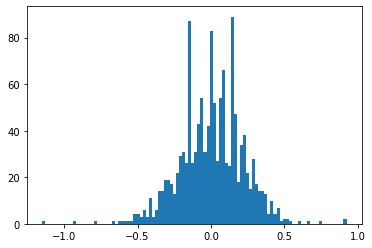

In [3]:
import matplotlib.pyplot as plt
plt.hist(y_train, bins = 100)

(-0.5, 319.5, 159.5, -0.5)

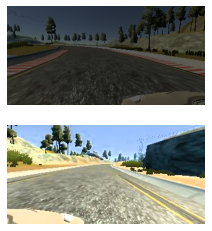

In [34]:
import matplotlib.pyplot as plt
idx = np.int(CONFIG['batch_size'] * np.random.rand())

plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(np.uint8(X_train[idx]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(np.uint8(X_train[idx+1]), cv2.COLOR_BGR2RGB))
plt.axis('off')

# Model

In [18]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Conv2D(24, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
model.add(Conv2D(36, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
model.add(Conv2D(48, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
model.add(Conv2D(64, kernel_size = (3, 3), strides= (2, 1), padding= 'valid', activation='relu'))
model.add(Conv2D(64, kernel_size = (3, 3), strides= (2, 1), padding= 'valid', activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5) 

model.save('model.h5')


In [3]:
import numpy as np
import csv
import cv2

env = 0

# Activate below when using Local Workspace
PATH_LOCAL            = './data/IMG/'
PATH_CSV_LOCAL        = "./data/driving_log.csv"

# Activate below when using Udacity Workspace
PATH_UDC            = '/opt/carnd_p3/data/IMG/'
PATH_CSV_UDC        = "/opt/carnd_p3/data/driving_log.csv"

# PATH
if env == 0:
    PATH        = PATH_LOCAL
    path_csv    = PATH_CSV_LOCAL
    
elif env == 1:
    PATH        = PATH_UDC
    path_csv    = PATH_CSV_UDC
    
else:
    raise('Invalid Argument')


# Reading Data
with open(path_csv, 'r') as f:
    reader  = csv.reader(f)
    data    = [row for row in reader][1:]
print("Reading CSV file completed")

X           = np.zeros(shape=(len(data), 160, 320, 3), dtype=np.float32)
y_steer     = np.zeros(shape=(len(data),), dtype=np.float32)


for idx, row in enumerate(data):
    ct_path, lt_path, rt_path, steer, throttle, brake, speed = row

    f       = ct_path.split('/')[-1]
    image   = np.float32(cv2.imread(PATH + f))
    steer   = steer

    X[idx] = image
    y_steer[idx] = steer

# from keras.models import Sequential, Model
# from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout

# X_train = X
# y_train = y_steer

# model = Sequential()
# model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
# model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
# model.add(Conv2D(24, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
# model.add(Conv2D(36, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
# model.add(Conv2D(48, kernel_size = (5, 5), strides= (2, 2), padding= 'valid', activation='relu'))
# model.add(Conv2D(64, kernel_size = (3, 3), strides= (2, 1), padding= 'valid', activation='relu'))
# model.add(Conv2D(64, kernel_size = (3, 3), strides= (2, 1), padding= 'valid', activation='relu'))
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(1))

# print(model.summary())

# model.compile(loss = 'mse', optimizer = 'adam')
# model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 5) 

# model.save('model.h5')

Reading CSV file completed


In [7]:
print(X.shape, y_steer.shape)
print(type(X), y_steer.dtype)

(8036, 160, 320, 3) (8036,)
<class 'numpy.ndarray'> float32
